**Importing modules**

In [48]:
import numpy as np
import pandas as pd

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from collections import Counter

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr

import seaborn as sns

**Setup Matplotlib**

In [6]:
%matplotlib inline
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]=12

colors=[(0,0.37,0.63), (0.863, 0.078, 0.235), (1, 0.84, 0)]
n_bins=3
cmap_name='my_list'
cmap=clr.LinearSegmentedColormap.from_list(cmap_name,colors,N=n_bins)

**Loading Data**

In [ ]:
data=pd.read_csv("data/adiabatic_1000_sk54.csv")
X=data[['T_0','X_fu']]
y=data['Label']
T_ad_K=data['T_ad_K']
CH2O=data['CH2O']


We plot the temperature and formaldehyde, which defines the low and high temperature ignition behavior in the 3 three classes (low T, high T, no ignition)

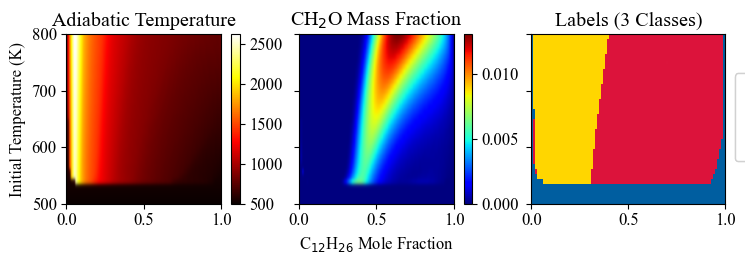

In [12]:
fig, axs= plt.subplots(1,3,figsize=(8.5,2.2),sharey=True)
image=axs[0].imshow(np.flipud(np.array(T_ad_K).reshape(34,100)),extent=[0,1,500,800],aspect='auto',interpolation='gaussian',cmap='hot')
axs[0].set_title('Adiabatic Temperature')
axs[0].set_ylabel('Initial Temperature (K)')
fig.colorbar(image, ax=axs[0])

image=axs[1].imshow(np.flipud(np.array(CH2O).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'gaussian',cmap = 'jet')
axs[1].set_title(r'CH$_2$O Mass Fraction')
axs[1].set_xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
fig.colorbar(image, ax=axs[1])

axs[2].imshow(np.flipud(np.array(y).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
axs[2].set_title('Labels (3 Classes)')

my_scatter = axs[2].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)
legend1 = axs[2].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignition",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[2].add_artist(legend1)

**Train and Validation**

In [13]:
seed=42 #Initialize seed for random components in ML algorithms
X_train, X_test_dev, y_train, y_test_dev = train_test_split(X, y, test_size=0.4, random_state=seed,stratify=y)
X_dev,X_test,y_dev,y_test=train_test_split(X_test_dev,y_test_dev,test_size=0.5,random_state=seed,stratify=y_test_dev)


Train=60.0 Dev=20.0 Test=20.0


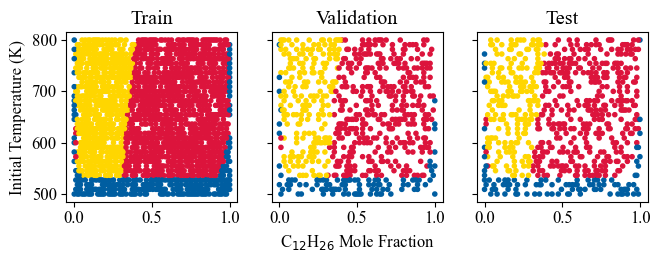

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.2), sharey=True)

axs[0].scatter(X_train.X_fu, X_train.T_0, c=y_train, cmap=cmap, marker='.')
axs[0].set_ylabel('Initial Temperature (K)')
axs[0].set_title('Train')

axs[1].scatter(X_dev.X_fu, X_dev.T_0, c=y_dev, cmap=cmap, marker='.')
axs[1].set_xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
axs[1].set_title('Validation')

axs[2].scatter(X_test.X_fu, X_test.T_0, c=y_test, cmap=cmap, marker='.')
axs[2].set_title('Test')

print("Train=" + str(len(y_train)/len(y)*100)+" Dev="+str(len(y_dev)/len(y)*100)+ " Test="+str(len(y_test)/len(y)*100))


The training set here will be used to fit the model. The test set will used to ensure that the trained model performs well on unseen data. The validation set acts as a test set in hyperparameter tuning.

We first normalize the dataset with a preprocessing function. This makes training easier for certain ML algortihms during gradient descent as all dimensions of the optimization manifold will be around the same scales.

In [16]:
X_train_scaled=preprocessing.StandardScaler().fit_transform(X_train)
X_dev_scaled=preprocessing.StandardScaler().fit_transform(X_dev)
X_test_scaled=preprocessing.StandardScaler().fit_transform(X_test)
X_decision_boundary=preprocessing.StandardScaler().fit_transform(X)

We use the accuracy score as performance metric to ensure that our hyperparameters of our ML model is tuned.

In [18]:
C_range=[1e-2,1e-1,1,10,1e2,1e3,1e4]
best_acc=-1
best_C=0
best_logReg=None
for C in C_range:
    logReg=LogisticRegression(C=C,random_state=seed).fit(X_train_scaled,y_train)
    y_train_pred=logReg.predict(X_train_scaled)
    y_dev_pred=logReg.predict(X_dev_scaled)
    train_acc=metrics.accuracy_score(y_train,y_train_pred)
    dev_acc=metrics.accuracy_score(y_dev,y_dev_pred)
    if dev_acc > best_acc:
        best_acc=dev_acc
        best_C=C
        best_logReg=logReg
print("The best C is %0.2f with an accuracy score of %0.5f"
      % (best_C, best_acc))

The best C is 1.00 with an accuracy score of 0.89265


In [21]:
y_test_pred=best_logReg.predict(X_test_scaled)
test_acc=metrics.accuracy_score(y_test,y_test_pred)
print("The test accuracy is ", test_acc)

The test accuracy is  0.8926470588235295


**Hyperparameter Search: SVC**

we introduce hyperparameter tuning via a k-fold cross-validation approach for our problem.

In [22]:
X_trainCV=X_dev
y_trainCV=y_dev 
X_trainCV_scaled=preprocessing.StandardScaler().fit_transform(X_trainCV)

In [85]:
C_range = np.logspace(0.1, 1, 110) 
gamma_range = np.logspace(0.01, 0.1, 1) 
param_grid = dict(gamma=gamma_range, C=C_range)

cv = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=seed)
grid = GridSearchCV(SVC(kernel='linear'), param_grid, cv=cv)
grid.fit(X_trainCV_scaled, y_trainCV)

print("The best parameters are ", grid.best_params_, " with a score of ", grid.best_score_)

The best parameters are  {'C': np.float64(3.076616710021804), 'gamma': np.float64(1.023292992280754)}  with a score of  0.9068627450980391


([<matplotlib.axis.YTick at 0x1eaa38a1f10>,
 [Text(0, 0, '$10^{-9}$'),
  Text(0, 2, '$10^{-7}$'),
  Text(0, 4, '$10^{-5}$'),
  Text(0, 6, '$10^{-3}$'),
  Text(0, 8, '$10^{-1}$'),
  Text(0, 10, '$10^{1}$'),
  Text(0, 12, '$10^{3}$')])

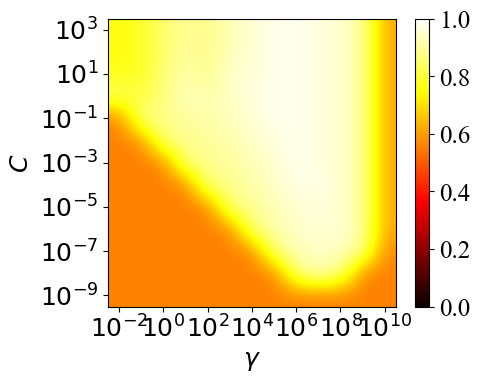

In [28]:
%matplotlib inline
# Draw heatmap of the validation accuracy as a function of gamma and C
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]=18
scores=grid.cv_results_['mean_test_score'].reshape(len(C_range), len(gamma_range))  

plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
plt.imshow(scores, interpolation='bicubic', cmap=plt.cm.hot,origin='lower')
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$C$')
plt.colorbar()
plt.clim([0,1])
fmt_C = [r'$10^{%d}$' % np.log10(i) for i in C_range.tolist()]
fmt_gamma = [r'$10^{%d}$' % np.log10(i) for i in gamma_range.tolist()]
plt.xticks(np.arange(len(gamma_range))[::2], fmt_C[::2],)
plt.yticks(np.arange(len(C_range))[::2], fmt_gamma[::2])

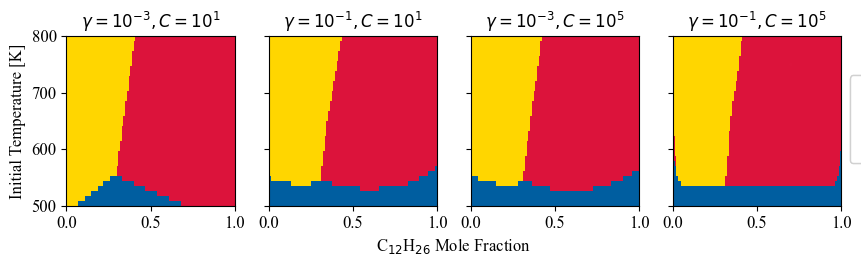

In [29]:
# Fit SVM for 4 different hyperparameters
C_2d_range = [1e1, 1e5]
gamma_2d_range = [1e-3, 1e-1]
classifiers = []
for C in C_2d_range:
    for gamma in gamma_2d_range:
        clf = SVC(C=C, gamma=gamma)
        clf.fit(X_trainCV_scaled, y_trainCV)
        classifiers.append((C, gamma, clf))

# Visualization of parameter effects
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12
fig, axs = plt.subplots(1, 4, figsize=(10, 2.2), sharey=True)
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel(r"C$_{12}$H$_{26}$ Mole Fraction")
axs[0].set_ylabel("Initial Temperature [K]")
for (k, (C, gamma, clf)) in enumerate(classifiers):
    # visualize decision function for these parameters
    axs[k].set_title(r"$\gamma=10^{%d} , C=10^%d$" % (np.log10(gamma), np.log10(C)),
              size='medium')
    axs[k].imshow(np.flipud(clf.predict(X_decision_boundary).reshape(34,100)),extent=[0,1,500,800]
           ,aspect='auto',interpolation = 'none',cmap = cmap)
    # visualize parameter's effect on decision function

my_scatter = axs[3].scatter([0,0.7,0.2],[500,750,750],c=[0,1,2],cmap=cmap,marker='.',s=12)

legend1 = axs[3].legend(*(my_scatter.legend_elements()[0],["No Ignition",r"Low $T$ Ignitiozn",r"High $T$ Ignition"]),
                    loc=(1.05,0.25),ncol = 1,columnspacing=-0.2)
axs[3].add_artist(legend1)

**Hyperparameter search: Logistic regression** 

In [30]:
C_range=[1e-2,1e-1,1,10,1e2,1e3,1e4]
param_grid=dict(C=C_range)
cv=StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=seed)
grid=GridSearchCV(LogisticRegression(), param_grid, cv=cv)
grid.fit(X_trainCV_scaled, y_trainCV)
print("The best parameters are ", grid.best_params_, " with a score of ", grid.best_score_)

The best parameters are  {'C': 100.0}  with a score of  0.875


**Hyperparameter search: Decision Tree**

In [55]:
param_grid = {
    'min_samples_split': [2, 5, 10, 20, 50, 100],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_depth': [None, 10, 20, 30],
    'criterion': ['gini', 'entropy']
}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
grid = GridSearchCV(
    DecisionTreeClassifier(),
    param_grid=param_grid,
    cv=cv,
    scoring='f1_macro',  
    n_jobs=-1
)
grid.fit(X_trainCV_scaled, y_trainCV)
print("The best parameters are ", grid.best_params_, " with a score of ", grid.best_score_)

The best parameters are  {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}  with a score of  0.972055919381902


**Hyperparameter search: Random Forests**

In [ ]:
param_grid = {
    'min_samples_leaf': [2, 5, 10, 20, 50, 100],
    'n_estimators': [10, 20, 50],
    'max_depth': [1, 5, 10],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=seed)
random_search = RandomizedSearchCV(
    RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=50,  # Number of random combinations to try
    cv=cv,
    random_state=seed,
    n_jobs=-1  # Use all available processors
)
random_search.fit(X_trainCV_scaled, y_trainCV)
print("The best parameters are ", random_search.best_params_, " with a score of ", random_search.best_score_)

The best parameters are  {'n_estimators': 50, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini'}  with a score of  0.973529411764706


**Benchmarking Classifiers**

In [ ]:
train_size_list=[0.01,0.1,0.15,0.2,0.25,0.3,0.5]
from imblearn.over_sampling import SMOTE
logReg_i_list=[]
dt_i_list=[]
rf_i_list=[]
svc_i_list=[]


tmp_list=[]
for train_size in train_size_list:
    X_train_i, Xtmp, y_train_i, ytmp = train_test_split(X_train, y_train, train_size=train_size, random_state=seed, stratify=y_train)
    
    X_scaled_i=preprocessing.StandardScaler().fit_transform(X_train_i)
    X_test_scaled_i = preprocessing.StandardScaler().fit_transform(Xtmp)

    logReg=LogisticRegression(random_state=seed,C=1000).fit(X_scaled_i,y_train_i)
    dt=DecisionTreeClassifier(max_features='sqrt',min_samples_split=10,min_samples_leaf=5,ccp_alpha=0.01,random_state=seed,criterion='entropy').fit(X_scaled_i,y_train_i)
    rf=RandomForestClassifier(n_estimators=50,max_depth=5,max_features='sqrt',random_state=seed,min_samples_split=10, min_samples_leaf=5,criterion='entropy').fit(X_scaled_i,y_train_i)
    svc=SVC(C=1e5, gamma=1e-3, kernel='rbf',random_state=seed,tol=1e-3).fit(X_scaled_i,y_train_i)

    y_logReg_i=logReg.predict(X_test_scaled_i)
    y_dt_i=dt.predict(X_test_scaled_i)
    y_rf_i=rf.predict(X_test_scaled_i)
    y_svc_i=svc.predict(X_test_scaled_i)

    logReg_i_list.append(metrics.accuracy_score(ytmp,y_logReg_i))
    dt_i_list.append(metrics.accuracy_score(ytmp,y_dt_i))
    rf_i_list.append(metrics.accuracy_score(ytmp,y_rf_i))
    svc_i_list.append(metrics.accuracy_score(ytmp,y_svc_i))
    
print(logReg_i_list)
print(dt_i_list)
print(rf_i_list)
print(svc_i_list)

[0.8683168316831683, 0.8965141612200436, 0.8979238754325259, 0.8921568627450981, 0.9, 0.9061624649859944, 0.9049019607843137, 0.9047619047619048]
[0.49554455445544554, 0.9264705882352942, 0.9002306805074971, 0.9332107843137255, 0.9398692810457516, 0.9376750700280112, 0.9598039215686275, 0.8571428571428571]
[0.8247524752475247, 0.9177559912854031, 0.9250288350634371, 0.9534313725490197, 0.9457516339869281, 0.9635854341736695, 0.9656862745098039, 0.8095238095238095]
[0.8727722772277228, 0.9330065359477124, 0.9521337946943483, 0.9509803921568627, 0.9418300653594771, 0.9558823529411765, 0.9549019607843138, 0.8095238095238095]


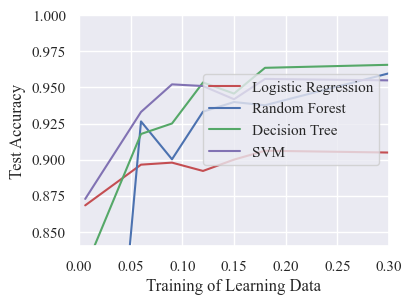

In [96]:
sns.set(style="darkgrid")
plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]=12
fig, axs = plt.subplots(1, 1, figsize=(4, 3))

plt.plot(np.array(train_size_list)*0.6, logReg_i_list,'r', label='Logistic Regression')
plt.plot(np.array(train_size_list)*0.6, dt_i_list,'b', label='Random Forest')
plt.plot(np.array(train_size_list)*0.6, rf_i_list,'g', label='Decision Tree')
plt.plot(np.array(train_size_list)*0.6, svc_i_list,'m', label='SVM') 

plt.xlim([0,0.3])
plt.ylim([0.84,1])

plt.legend(loc=[0.4,0.35])
plt.xlabel('Training of Learning Data')
plt.ylabel('Test Accuracy')

plt.savefig('learning_curves.png', format='pdf', bbox_inches='tight')


Here we see that most algorithms (except Logistic Regression) converge around accuracy of 0.97.
we compare computational cost during (training and predicting/inference) of the ML algorithms.

In [81]:
X_scaled = preprocessing.StandardScaler().fit_transform(X_train)

logReg = LogisticRegression(C = 1000).fit(X_scaled_i, y_train_i)
dt = DecisionTreeClassifier(criterion = 'entropy').fit(X_scaled_i, y_train_i)
rf = RandomForestClassifier(n_estimators = 20,criterion = 'entropy').fit(X_scaled_i, y_train_i)    
svc = SVC(gamma=0.1, C = 1e5, tol = 1e-4, kernel = 'rbf').fit(X_scaled_i, y_train_i)

my_time = %timeit -n 1 -r 3 -o  logReg
logReg_traintime=my_time.best

my_time = %timeit -n 1 -r 3 -o  dt
dt_traintime=my_time.best

my_time = %timeit -n 1 -r 3 -o  rf
rf_traintime=my_time.best

my_time = %timeit -n 1 -r 3 -o  svc
svc_traintime=my_time.best

print("--")
my_time = %timeit -n 1 -r 3 -o logReg.predict(X_test_scaled)
logReg_testtime = my_time.best 
my_time = %timeit -n 1 -r 3 -o dt.predict(X_test_scaled)
dt_testtime= my_time.best
my_time = %timeit -n 1 -r 3 -o rf.predict(X_test_scaled)
rf_testtime = my_time.best
my_time = %timeit -n 1 -r 3 -o svc.predict(X_test_scaled)
svc_testtime = my_time.best


367 ns ± 205 ns per loop (mean ± std. dev. of 3 runs, 1 loop each)
367 ns ± 249 ns per loop (mean ± std. dev. of 3 runs, 1 loop each)
300 ns ± 141 ns per loop (mean ± std. dev. of 3 runs, 1 loop each)
267 ns ± 94.3 ns per loop (mean ± std. dev. of 3 runs, 1 loop each)
--
183 μs ± 70.4 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)
142 μs ± 46.7 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.5 ms ± 234 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)
1.42 ms ± 150 μs per loop (mean ± std. dev. of 3 runs, 1 loop each)
